# Homework 6

In this homework, you will implement and explore learning using Gaussian mixture generative and linear discriminative models. The goal is both to review the mechanics of fitting the models, and even more so to gain an appreciation of their relative benefits.

We provide you with most of the code required in these parts -- your primary job will be to run the code and inspect and analyze the outcomes. Additionally, you will have to implement the diagonal mixture model you studied in written homework, and the logistic loss function and its derivative for use in the discriminative models.

There are a number of programming **tasks** and **questions** in this homework.
- For **tasks**, you will need to either **add code between comments "`#### TASK N CODE`"** to complete them or **modify code between those comments**. **DO NOT delete the comments "#### TASK N CODE". This is for graders' reference and you might not get full points if you tamper with these comments.**
- For **questions**, you will need to answer in a few sentences between the given lines.
- For **optional tasks and questions**, you are **NOT required to turn them in**. However, we encourage you to complete them as they are good practice.
- For **challenge-optional tasks**, you are **NOT required to turn them in**. However, you will receive extra credit for completing the challenge.

## Imports

In [1]:
!gdown 1-ELYUcVSdiYKoT84OaSQu4LirxcKbUdl

Downloading...
From (original): https://drive.google.com/uc?id=1-ELYUcVSdiYKoT84OaSQu4LirxcKbUdl
From (redirected): https://drive.google.com/uc?id=1-ELYUcVSdiYKoT84OaSQu4LirxcKbUdl&confirm=t&uuid=64aee622-5c7d-4c95-b899-6338cd883909
To: c:\Users\matth\OneDrive\Documents\School\Senior Year\Winter Quarter\TTIC 31020\hw6\hw6 experimental\utils.py

  0%|          | 0.00/7.47k [00:00<?, ?B/s]
100%|██████████| 7.47k/7.47k [00:00<00:00, 29.5MB/s]


In [1]:
import numpy as np
from numpy import array,newaxis,ones,zeros,shape
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, det, inv, pinv, eigvalsh # scipy.linalg is a bit more full-features, includes additional routines,
                                            # and subsumes numpy.linalg.  It's generally its better to use scipy.linalg.
import numpy.random as random
from matplotlib.colors import ListedColormap
np.seterr(over='ignore',under='ignore') # don't issues warnings for overflow and underflow errors

from utils import *

## Preliminaries

As you have seen in homework 4, we first define `Classifier` as an abstract class that can only be subclassed. We can build on top of this to get the various different classifiers we will eventually be interested in, and this keeps us from having to implement reusable functions like `predict`, `score`, and `error` over and over.

In [2]:
class Classifier:
    def predict_log_proba(self,X):
        # This needs to be implemented by a subclass
        raise NotImplementedError
    def predict(self,X):
        """Returns Bayes Optimal predicted labels"""
        return np.array(self.labels)[np.argmax(self.predict_log_proba(X),1)]
    def score(self,X,y):
        """Accuracy rate"""
        return np.mean(self.predict(X)==y)
    def error(self,X,y):
        """Error rate (empirical 0/1 error on the give data)"""
        return 1-self.score(X,y)

In particular, we can start by thinking about linear predictor with respect to some feature map.  Although in this notebook we only used linear predictors with respect to `affine_phi` (defined below), we also included an implementation of a quadratic feature map, both to emphasize that we can use different feature maps, and to encourage you to experiment with it.

In [3]:
def homogeneous_phi(x):
    return x
def affine_phi(x):
    return np.hstack( ( np.ones( (np.size(x,0),1) ) , x ) )
def quad_phi(x):
    return np.hstack( ( np.ones( (np.size(x,0),1) ) , x , x[:,newaxis,:]*x[:,:,newaxis]) )

class LinearClassifier(Classifier):
    """A based class for linear classifiers.

    Uses the weight vector self.w, but this base class does not define self.w.
    It needs to be defined (e.g. learned from data) in a subclass."""
    def __init__(self,phi=affine_phi):
        self.phi=phi
    def predict(self,X):
        return np.sign(self.phi(X)@self.w)

## Generative Modelling

In the generative approach, we assume that the data we receive were generated using some known model, and we then wish to determine the parameters of that model.

Let us first implement the different generative models we will explore. These are implemented in Python using the **object-oriented** paradigm. Familiarize yourself with that if you are not already familiar. We implement several classes that build on top of `GaussianMix` so that we can run various different algorithms. The base class `GaussianMix` also has the ability to generate points from a mixture of Gaussians with means, covariances, and proportions defined while instantiating the class. We use this to generate several of the datasets we later consider.


`GaussianMix` subclasses `Classifier` because we are interested in how that mixture behaves as a classifier. Then, once we learn the appropriate parameters from data, we may wish to compute what that generative model predicts for new points, so `LearnedGaussianMix` subclasses `GaussianMix`. From here, `LDA`, `DiagGM`, `DiagLDA`, etc., all differ in specifically which parameters are learnt and which are assumed, and so they subclass `LearnedGaussianMix`.

### [Task 1] Finish the implementation of DiagGM
**First**, read over the code in the following cells and familiarize yourself with what methods are available and what the different pieces do.

**Second**, fill in the code for DiagGM in the third cell.

In [4]:
def plogdeth(A):
    """For a full-rank Hermitian matrix, return log(det(A)).  If not full-rank, ignore zero eigenvalues."""
    v = eigvalsh(A)
    return np.sum(np.log(v[~np.isclose(v,0)]))
    # first taking the log and then summing is safer and more numerically stable and acurate, as it avoids really big numbers

In [5]:
class GaussianMix(Classifier):
    """Represents a mixture of Gaussians, with one label per Gaussian."""
    def __init__(self,mus=[np.array([-1,0]),np.array([1,0])],Sigmas=1,ps=None,labels=[-1,1]):
            """Instantiate the mixture based on specified parameters"""
            from numbers import Number
            d = len(mus[0]) # the dimensionality
            if isinstance(Sigmas,Number): # A scalar can be passed for Sigmas, indicating a scaled identity covariance
                Sigmas = Sigmas*np.eye(d)
            if isinstance(Sigmas,np.ndarray): # If only a single matrix is passed, it is used as the covariance for all classes
                Sigmas = [Sigmas]*len(labels)
            if ps is None: # default to uniform over the components
                ps = np.array([1/len(labels)]*len(labels))
            self.d = d
            self.mus=mus
            self.Sigmas=Sigmas
            self.ps=ps
            self.labels=labels
    def generate(self,m):
        """Generate m samples from the mixture"""
        y = random.choice(self.labels,p=self.ps,size=m)
        x = np.empty((m,self.d))
        for label,mu,Sigma in zip(self.labels,self.mus,self.Sigmas):
            thism = sum(y==label)
            x[y==label] = random.randn(thism,self.d)@sqrtm(Sigma)+mu
        return x,y

    def predict_log_proba(self,x):
        """Log posteriors.
        Returns logp, where logp[i,j]=log P(labels[j]|x[i,:])"""
        return np.stack([np.log(p) -0.5*np.sum(((x-mu)@pinv(Sigma))*(x-mu),1) -0.5*plogdeth(2*np.pi*Sigma)
                             for p,mu,Sigma in zip(self.ps,self.mus,self.Sigmas)]).T

    ##################################################################################################
    # The following methods are not used in this homework.  They are provided to you to emphasize how
    # the discriminant, and Bayes classifier, for a Gaussian mixture, is linear or quadratic.  We encourage
    # you to expriment with these methods and study them
    ##################################################################################################
    def lin_logpost(self):
        """returns b,w, such that log P(labels[i]|x) \propto b[i] + w[i,:]@x"""
        assert np.allclose(self.Sigmas)
        Sinv=pinv(self.Sigmas[0])
        mus = array(self.mus)
        b = np.log(self.ps) - 0.5 * sum(mus[:,newaxis,:]*mus[:,:,newaxis]*Sinv,axis=(1,2))
        w = mus@Sinv
        return b,w
    def quad_logpost(self):
        """returns b,w,H such that log P(labels[i]|x)=b[i] + w[i]@x + 0.5*x@H[i]@x"""
        Sinvs = [ pinv(Sigma) for Sigma in self.Sigmas ]
        b = [ np.log(p) - 0.5*mu@Sinv@mu +0.5*plogdeth(Sinv/(2*np.pi)) for p,mu,Sinv in zip(self.ps,self.mus,Sinvs)]
        w = [ mu@Sinv for mu,Sinv in zip(self.mus,Sinvs) ]
        H = [ -S for S in Sinvs]
        return b,w,H
    def lin_pred(self):
        """For two labels, return b,w such the discriminant is b+w@x"""
        bs,ws = self.lin_logpost()
        return bs[1]-bs[0],ws[1]-ws[0]
    def quad_pred(self):
        """For two labels, returns b,w,H such that the discriminant is b+w@x+x@H@x"""
        bs,ws,Hs = self.quad_logpost()
        return bs[1]-bs[0],ws[1]-ws[0],Hs[1]-Hs[0]
    def as_linear_predictor(self):
        """Returns a Linear Predictor (as a LinearClassifier instance) corresponding to the
        Bayes classifier for the mixture, if it is indeed linear."""
        clf = LinearClassifier()
        b,w = self.lin_pred()
        clf.w = np.block([b,w])
        return clf
    def as_quad_pred(self):
        """Returns a Quadratic Predctor (as a LinearClassifier instance over quadratic features)
        corresponding to the Bayes classifier for the mixture."""
        clf = LinearClassifier(phi=quad_phi)
        b,w,H = self.quad_pred()
        clf.w = np.block([b,w,np.ravel(H)])
        return clf

<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\p'
C:\Users\matth\AppData\Local\Temp\ipykernel_26684\1078603411.py:39: SyntaxWarning: invalid escape sequence '\p'
  """returns b,w, such that log P(labels[i]|x) \propto b[i] + w[i,:]@x"""


In [6]:
class LearnedGaussianMix(GaussianMix):
    def __init__(self,labels=None):
        '''Create a "blank" Gaussian Mixture, without parameters yet (and hence can't be used).
        Use self.fit(X,y) to fit the parameters to data'''
        self.labels=labels
    def fit(self,Xs,ys):
        if self.labels is None:
            self.labels = np.unique(ys)
        labels = self.labels
        ps=np.mean(ys[:,newaxis]==labels,0)
        mus = [ np.mean(Xs[ys==y,:],0) for y in labels]
        Sigmas = [ np.cov(Xs[ys==y].T,bias=True) for y in labels]
        GaussianMix.__init__(self,mus=mus,Sigmas=Sigmas,ps=ps,labels=labels)
class LDA(LearnedGaussianMix):
    """Covariances matrices constrained to be the same"""
    def fit(self,*args,**kwargs):
        super().fit(*args,**kwargs)
        self.Sigmas = [ np.sum( np.array(self.Sigmas) * self.ps[:,newaxis,newaxis],0) ] * len(self.labels)
class DiagGM(LearnedGaussianMix):
    """Covariances matrices constrained to be diagonal"""
    def fit(self,*args,**kwargs):
        super().fit(*args,**kwargs)
        #### TASK 1 CODE
        self.Sigmas = [np.diag(np.diag(Sigma)) for Sigma in self.Sigmas]
        #### TASK 1 CODE
class DiagLDA(LDA,DiagGM):
    """Covariance matrices constrained to be the same diagonal matrix"""
    pass
class SphericalGM(DiagGM):
    """Covariance matrices constrained to be spherical"""
    def fit(self,*args,**kwargs):
        super().fit(*args,**kwargs)
        self.Sigmas=[ np.mean(np.diag(Sigma))*np.eye(self.d) for Sigma in self.Sigmas]
class SphericalLDA(LDA,SphericalGM):
    """Covariance matrices constrained to be the same spherical"""
    pass
class UnitSphericalGM(SphericalLDA):
    """Covariance matrices constrained to be spherical with unit variance, i.e. identity"""
    def fit(self,*args,**kwargs):
        super().fit(*args,**kwargs)
        # going through the LDA and Spherical, or even calculating the covariance, is redundant,
        # but this is subclassed to indicate it has all the properties of them
        self.Sigmas=[ np.eye(self.d) ]*len(self.labels)

## Discriminative Modelling

We will fit discriminative models using Empirical Risk Minimization, i.e., by minimizing the training loss.  To miminmize the loss, we wll use[`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). This function implements many different gradient based optimization methods and defaults to using [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm). (It also implements methods that only use function evaluations, without gradients, as well as second order methods that also use the Hessian, but here we will focus on gradient based methods).  To use ['minimize'], we need to pass it functions returning the objective value and the gradient of the objective value.

We will consider loss functions of the form $\ell(\langle w,\phi(x)\rangle,y)=\text{loss}(y\langle w,\phi(x)\rangle)$ for a scalar function $\text{loss}$.  In particular, we will use the hinge loss, for which $\text{loss}(z)=[1-z]_+$ and the logistic loss, for which $\text{loss}(z)=\log(1+e^{-z})$.

### [Task 2] Looking for a great $\beta$ value

You need to complete two parts of this implementation:

1. The computation of training_grad inside the fit() method.

2. The computation of the logistic loss and its derivative in the subclass LogisticReg.  You can use the already implemented HingeReg as a template.

In [7]:
class ERMLinearClassifier(LinearClassifier):
    """Linear predictor trained by minimizing the (regularized) empirical risk, with respect to some loss function.

    This is a base class that does not define which loss function and which regularizer is used---these need to be
    defined in subclasses.  The loss function is defined in terms of a scalar function loss(z) where
    ell(prediction,y)=loss(y*prediction).

    In particular, in order to be used, base classes must define the following methods:
    loss_func(self,z) -> array of the same shape as z, with values loss(z)
    loss_derivative(self,z) -> array the same shape as z, with values loss'(z).

    The regularizer is defined via the methods regularizer(self,w) and its gradient regularizer_grad(self,w).
    In the based class, the regularizer is zero (no regularization).  It can be optionally implemented in a
    base class."""
    def __init__(self,lmb=0,*args,**kwargs):
        """lmb is the regularization tradeoff parameters.  Default lmb=0 for no regularization."""
        super().__init__()
        self.lmb=lmb
    def fit(self,X,y,verbose=False):
        """Fit the linear predictor by minimizing the empirical risk"""
        from scipy.optimize import minimize
        yphiX = y[:,newaxis]*self.phi(X)
        m,d = np.shape(yphiX)
        def training_obj(w):
            # training objective, for the given data, as a function of a predictor w
            return np.mean(self.loss_func(yphiX@w)) + self.lmb * self.regularizer(w)
        def training_grad(w):
            #### TASK 2 CODE
            # gradient of training_obj with respect to w
            # you will want to use self.loss_derivative and self.regularizer_grad
            return np.mean(self.loss_derivative(yphiX@w)[:,newaxis]*yphiX,0) + self.lmb*self.regularizer_grad(w)
            #### TASK 2 CODE
        minimization = minimize(training_obj, zeros(d), jac=training_grad)
        self.w = minimization.x
    def regularizer(self,w):
        return 0
    def regularizer_grad(self,w):
        return np.zeros(len(w))


class HingeReg(ERMLinearClassifier):
    def loss_func(self,z):
        return np.maximum(0,1-z)
    def loss_derivative(self,z):
        return -1*(z<1)

class LogisticReg(ERMLinearClassifier):
    def loss_func(self,z):
        #### TASK 2 CODE
        return np.log(1+np.exp(-z)) 
        #### TASK 2 CODE
    def loss_derivative(self,z):
        #### TASK 2 CODE
        return -1/(1+np.exp(z))
        #### TASK 2 CODE


class L2RegLinear(ERMLinearClassifier):
    def regularizer(self,w):
        return np.sum(w**2)/2
    def regularizer_grad(self,w):
        return w


class L1RegLinear(ERMLinearClassifier):
    def regularizer(self,w):
        return np.sum(np.abs(w))
    def regularizer_grad(self,w):
        return np.sign(w)


class LogisticL2Reg(LogisticReg,L2RegLinear):
    pass


class HingeL2Reg(HingeReg,L2RegLinear):
    pass


class LogisticL1Reg(LogisticReg,L1RegLinear):
    pass


class HingeL1Reg(HingeReg,L1RegLinear):
    pass

## Data Distributions

Let us now take a look at the different data distributions we will explore in this assignment. The distributions are implemented as functions that take an input m and return m iid draws from the distribution.  For each type of distribution we provide a possibly high dimensional variant, `source_k`, and a two dimensional variant `source_k_2d` that is easier to plot and interogate.  You should look at the scatter plots of the 2D examples to understand how the source distributions look like. The scatter plot function takes in some data, `X, y`, plots it on a 2D axis, and colors the points according to the labels.

The source distributions are created using functions that take parameters (such as the seperation between components or number of dimensions) and return the sampling functions.  You can try different variants of these source distributions.

### Mixture of Spherical Gaussians

This distribution is a mixture of two Gaussians with unit spherical covariance. Namely:
$$
\mathcal{D} \sim \frac 12 \mathcal{N}\left( \mu_+, I_d  \right) + \frac 12 \mathcal{N}\left( \mu_-, I_d  \right)\,,
$$
and $\mu_- = -\mu_+\,.$

In [9]:
def spherical_Gaussians(sep,d):
    return GaussianMix( mus=(np.block( [ -sep/2,zeros(d-1) ] ),
                             np.block( [  sep/2,zeros(d-1) ] ) ) ).generate

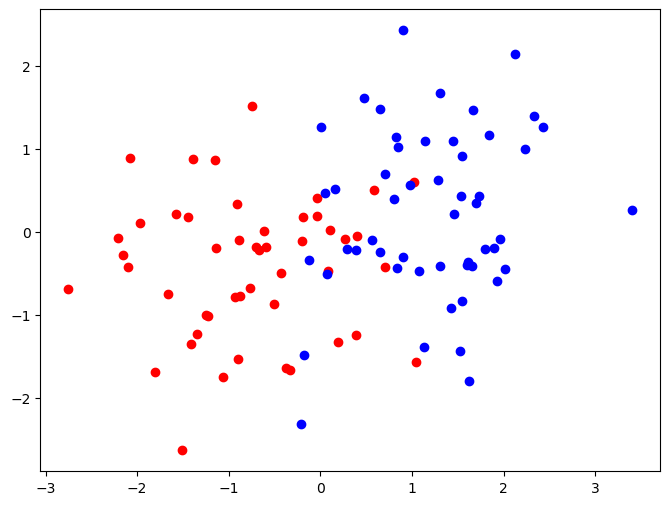

In [10]:
source_1 = spherical_Gaussians(sep=2,d=50)
source_1_2d = spherical_Gaussians(sep=2,d=2)

scatter_plot(*(source_1_2d(100)))

### Skewed Gaussians

This distribution is a mixture of two Gaussians, with means $\pm \mu$ and covariance $\Sigma = \begin{pmatrix} (s+1) & s & ... & s \\
s & (s+1) & ... & s \\
\vdots \\
s & s & ... & (s+1)\end{pmatrix}$ where $s$ is a skewness parameters.

In [11]:
def skewed_Gaussians(skew,sep,dim=2):
    Sigma = np.eye(dim)+skew*np.ones((dim,dim))
    dist = sep/np.linalg.norm(sqrtm(inv(Sigma))[:,0]) # distance between means along first coordinate s.t. the overlaps
                                     # between the Guassians would be as between two univariant Gaussians
                                     # with seperation 'sep'
    mu = np.block( [ dist/2 , np.zeros(dim-1)] )
    return GaussianMix(mus=(mu, -mu), Sigmas=Sigma ).generate


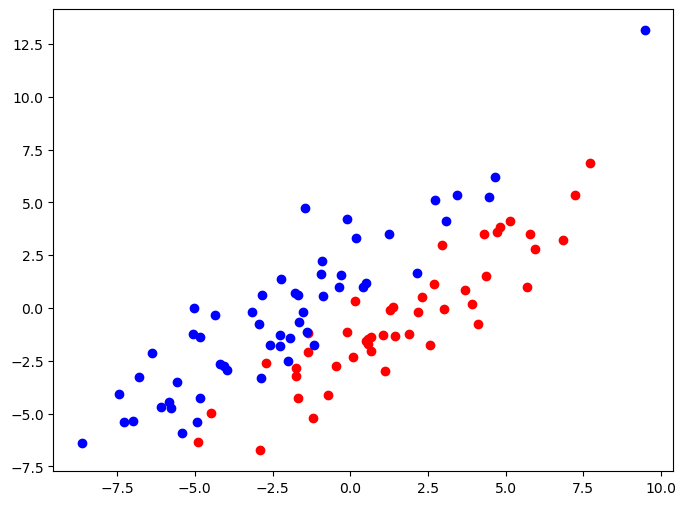

In [12]:
source_2 = skewed_Gaussians(skew=10,sep=3,dim=20)
source_2_2d = skewed_Gaussians(skew=10,sep=3)
scatter_plot(*(source_2_2d(100)))

### Horizontal-Vertical

This distribution is a mixture of two Gaussians, one with larger variance in the horizontal direction and the other with larger variance in the vertical direction, placed such that there is some overlap.

In [13]:
def horizontal_vertical(sep):
    return GaussianMix(mus=(np.array( [ sep,0] ),
                            np.array( [  0,0] ) ),
                       Sigmas=( np.diag([6,0.2])**2 , np.diag([0.7,10])**2 ) ).generate

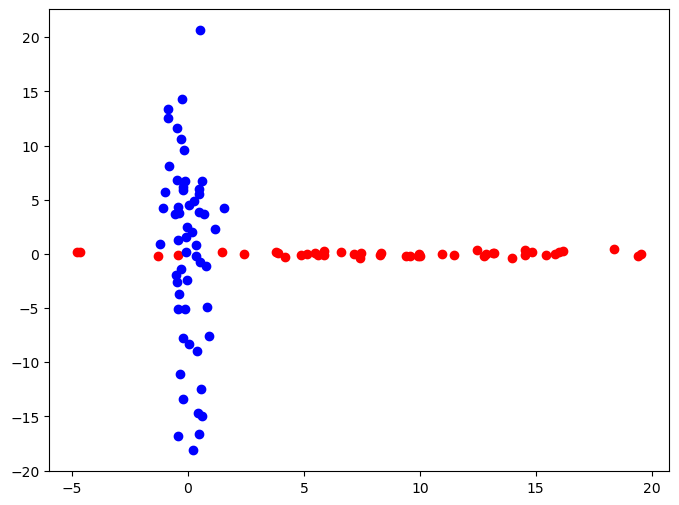

In [14]:
source_3 = horizontal_vertical(sep=10)

scatter_plot(*(source_3(100)))

### Heavy-Tailed

This distribution has three kinds of points: one where each component is generated from a heavy-tailed distribution and has positive label, one where each componenent is the negative of samples generated from a heavy-tailed distribution and has negative label, and finally, a small cluster of positive points placed in the negative region. The proportion of points that are in this cluster is set by the parameter $b\,,$ which is set to 0 for `source_4` and 0.1 for `source_5`.

There are many different definitions of "heavy-tailed," but the relevant one here is that the variance is infinite. The components are drawn from a Pareto distribution, which has density:
$$
f_\text{Pareto}(x) = \frac{1}{x^2}
$$

In [15]:
def ht_data(d=10, p=0.5, b=0.1):
    def ht_data_params(n):
        n_true_pts = np.random.binomial(n, 1-b)
        n_p = np.random.binomial(n_true_pts, p)
        X_p = 0.05+np.random.pareto(1, size=(d, n_p))
        X_n = -0.05-np.random.pareto(1, size=(d, n_true_pts - n_p))
        X_clust = np.random.multivariate_normal(mean=np.block([-20, -5*np.ones((d-1,))]), cov=np.eye(d), size=(n-n_true_pts,)).T
        y = np.hstack((np.ones(n_p,), -1*np.ones(n_true_pts-n_p), np.ones(n - n_true_pts)))
        x = np.hstack((X_p, X_n, X_clust))
        idxs = np.random.permutation(n)
        return x[:, idxs].T, y[idxs]

    return ht_data_params

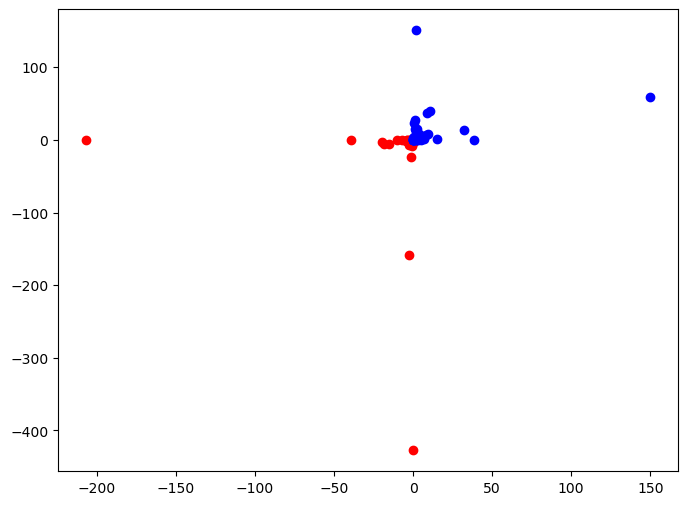

In [16]:
source_4 = ht_data(b=0)
source_4_2d = ht_data(d=2, b=0)

scatter_plot(*(source_4_2d(100)))

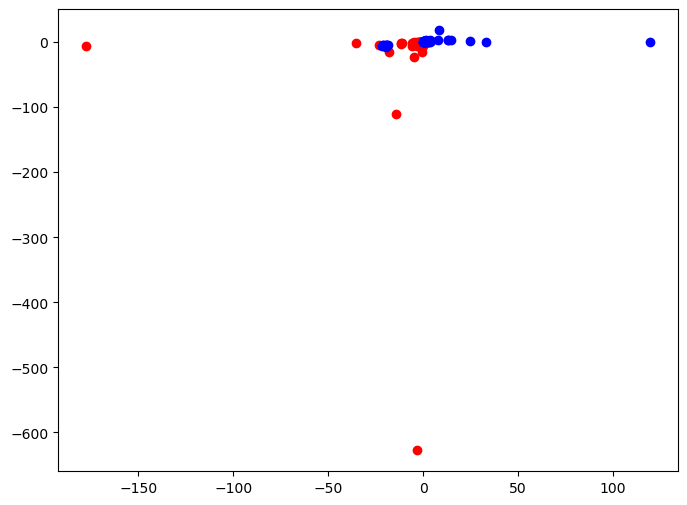

In [17]:
source_5 = ht_data()
source_5_2d = ht_data(d=2)

scatter_plot(*(source_5_2d(100)))

In order to understand how one particular method performs on one specific 2D data distribution, we can plot the decision boundary to see how it compares to the actual distribution.

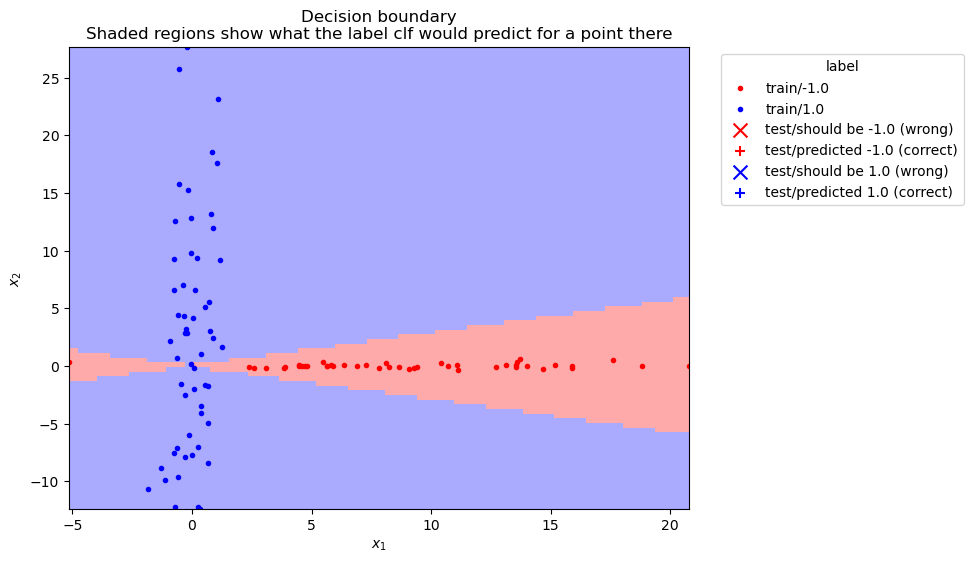

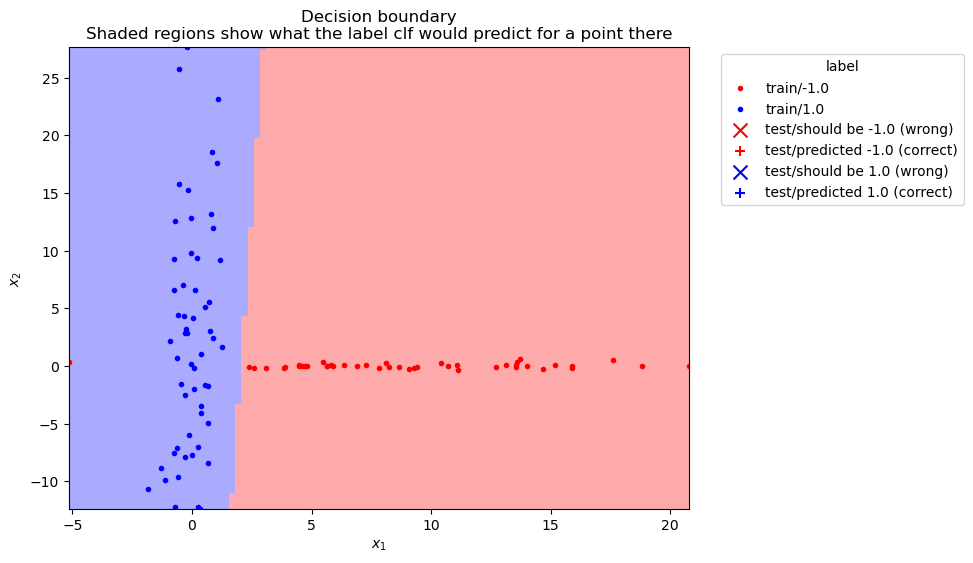

In [18]:
x,y = horizontal_vertical(sep=10)(100)
dgm = DiagGM()
dgm.fit(x,y)
linh = HingeReg()
linh.fit(x,y)
plot_decision_boundary(dgm,x,y)
plot_decision_boundary(linh,x,y)

However, to benchmark how these methods do on high-dimensional data, what we are really interested in is sample efficiency -- how much data does a given method require to succeed on a given dataset?

## Summary of Methods
There are five methods we want to explore in this homework:
* `UnitSphericalGM()`: This method fits the means but assumes a unit spherical covariance.
* `DiagGM()`: This method fits means and allows for a diagonal covariance, where different components have different covariances.
* `LDA()`: This method runs Linear Discrimnant Analysis.
* `LogisticReg()`: This method minimizes the Logistic Loss.
* `HingeReg()`: This method minimizes the Hinge Loss.

## Comparisons

Equipped with the desired code, let us now run some experiments to see how well different approaches perform on different datasets. Below we provide a function that allows you to try all the previously-described methods on a give source distribution (that is, on data generated by some provided sampler).

In [19]:
methods = { 'unispherical':UnitSphericalGM(), 'diag':DiagGM(), 'LDA':LDA(), 'logistic':LogisticReg(), 'hinge':HingeReg()}

def try_methods_on_data(datagen, methods=methods, max_train=300, test_size=1000, min_train=10, num_sizes=20,num_rep=10):
    test_x,test_y = datagen(test_size)
    train_sizes = np.linspace(min_train,max_train,num_sizes).astype(int)
    errors = { name:zeros(len(train_sizes)) for name in methods }
    for i,train_size in enumerate(train_sizes):
        for r in range(num_rep):
            train_x,train_y = datagen(train_size)
            for name,method in methods.items():
                method.fit(train_x,train_y)
                errors[name][i]+=method.error(test_x,test_y)/num_rep
    for name,errs in errors.items():
        plt.plot(train_sizes, errs, label=name)
    plt.legend()
    plt.xlabel("sample size")
    plt.ylabel("error")
    plt.show()
    return errors


In [23]:
sources = [source_1, source_2, source_3, source_4, source_5]
sources_2d = [source_1_2d, source_2_2d, source_3, source_4_2d, source_5_2d]

source 1


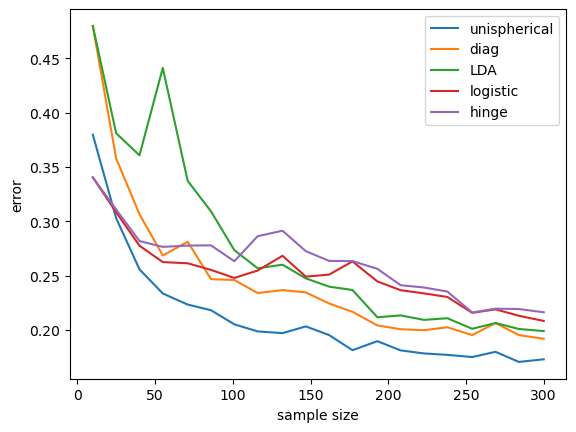

source 2


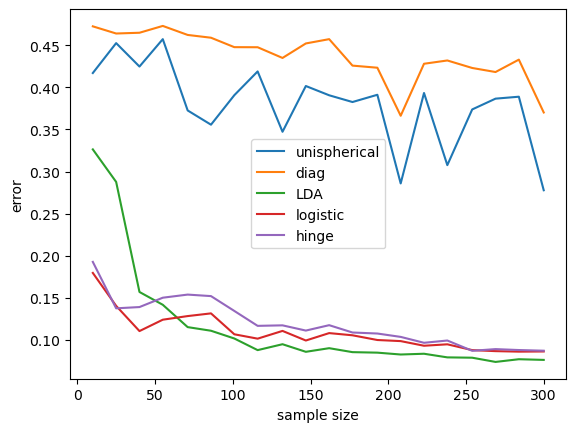

source 3


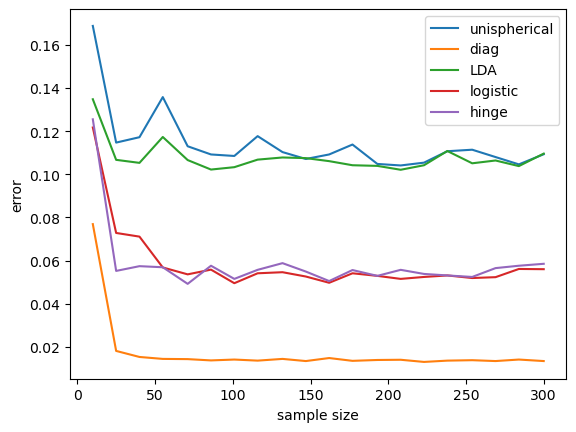

source 4


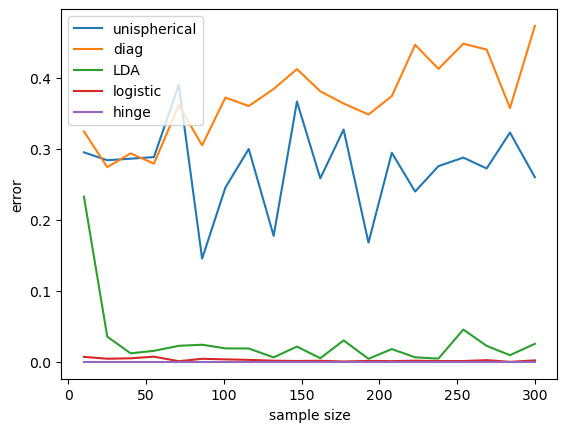

source 5


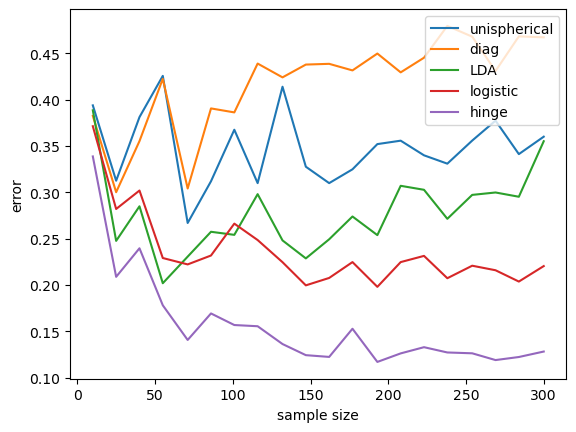

In [30]:
for i, source in enumerate(sources):
    print(f"source {i+1}")
    try_methods_on_data(source)

Source 2 Method Unispherical
Source 2 Method Diag


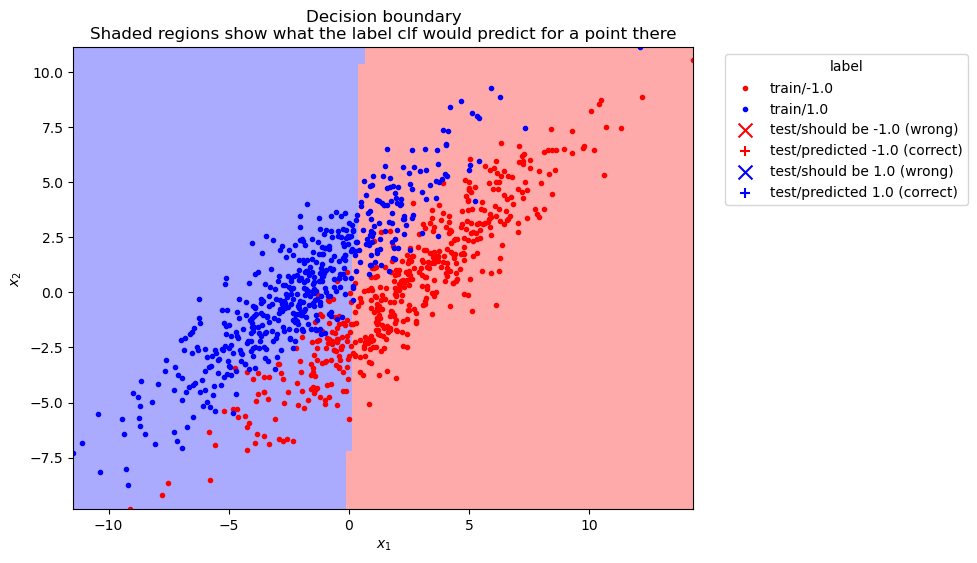

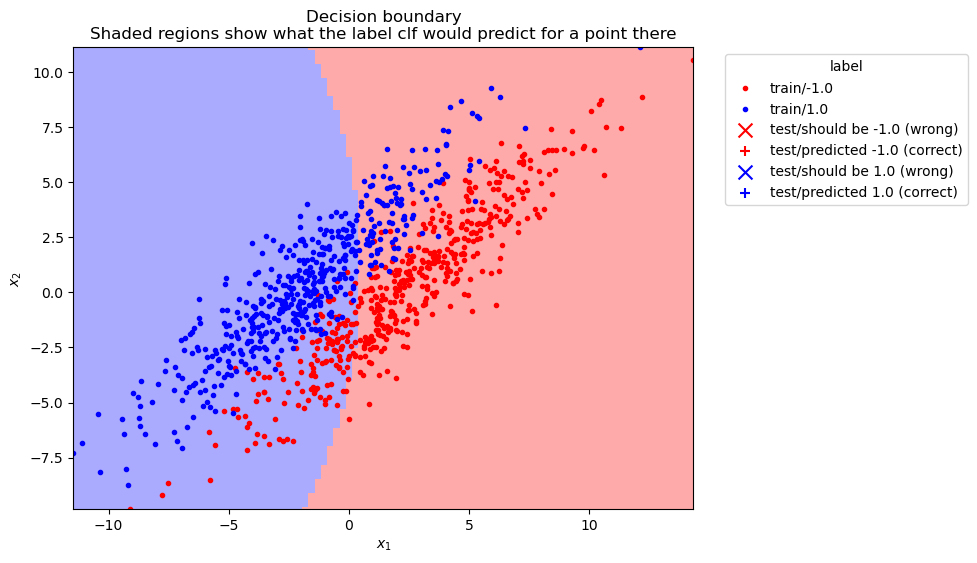

In [31]:
# source 2 decision boundaries
x,y = source_2_2d(1000)
clf = methods['unispherical']
clf.fit(x,y)
print(f'Source 2 Method Unispherical')
plot_decision_boundary(clf,x,y)
clf = methods['diag']
clf.fit(x,y)
print(f'Source 2 Method Diag')
plot_decision_boundary(clf,x,y)

Source 3 Method unispherical


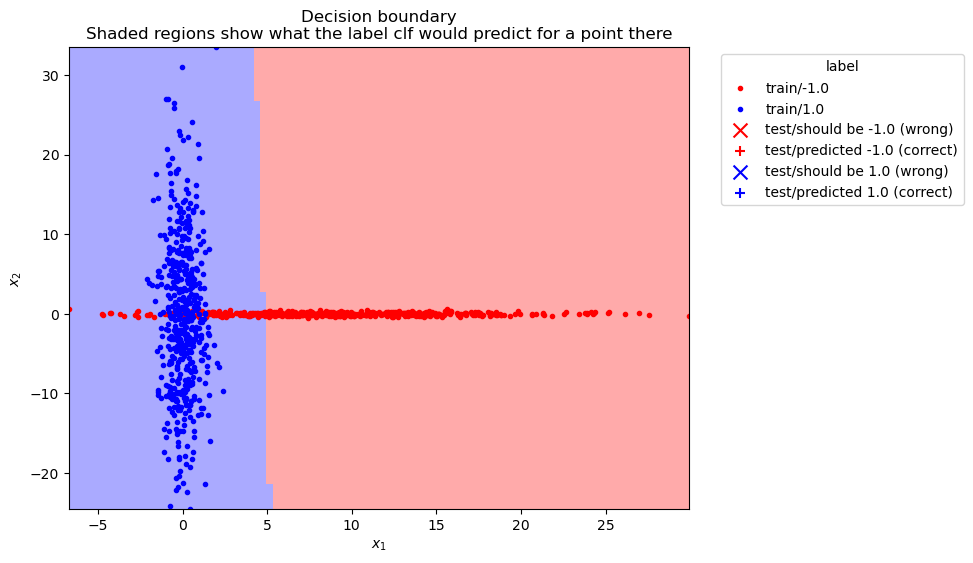

Source 3 Method diag


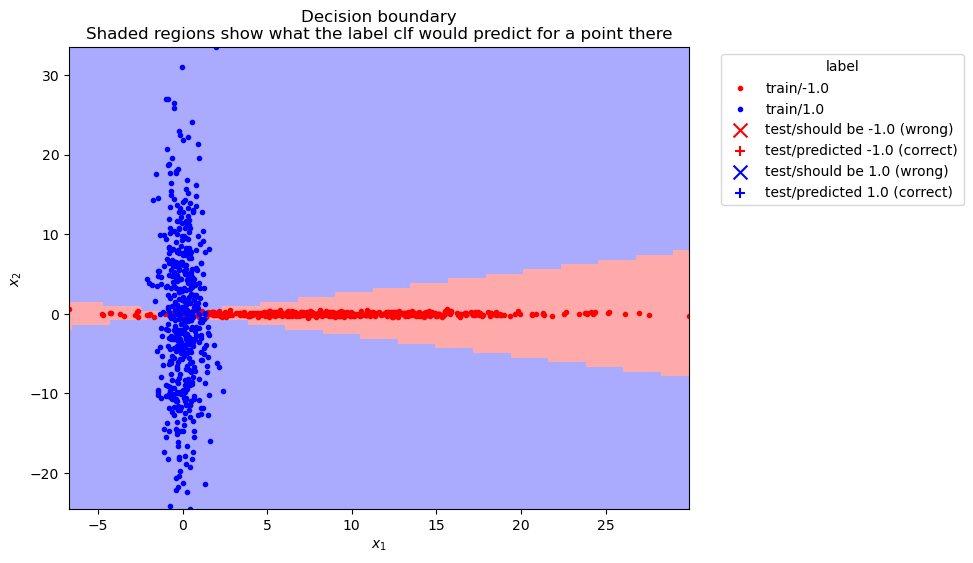

Source 3 Method LDA


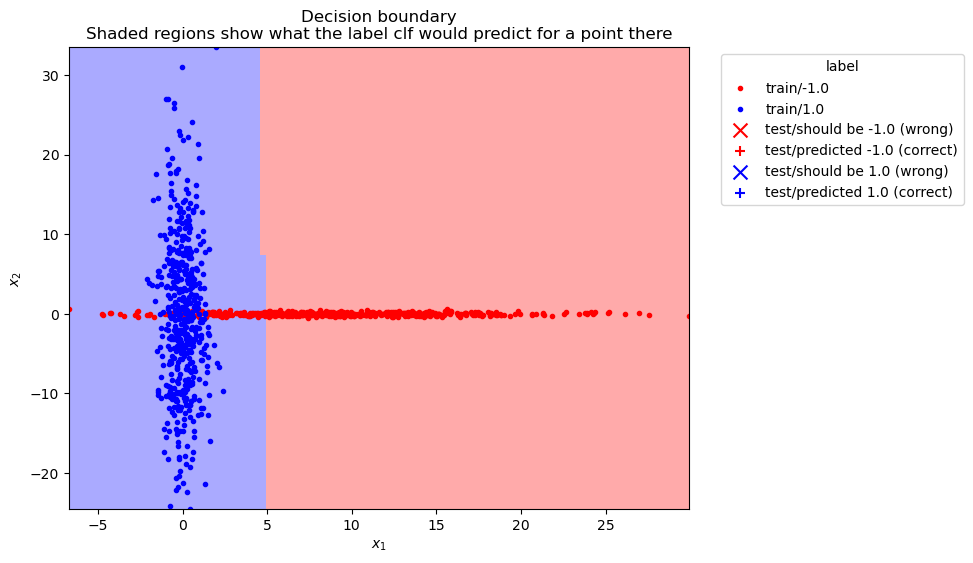

Source 3 Method logistic


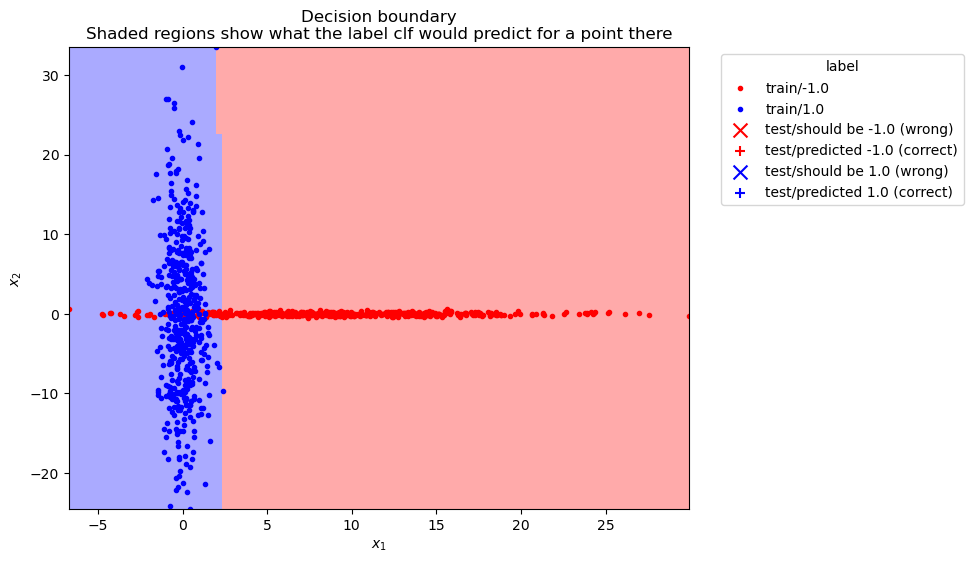

Source 3 Method hinge


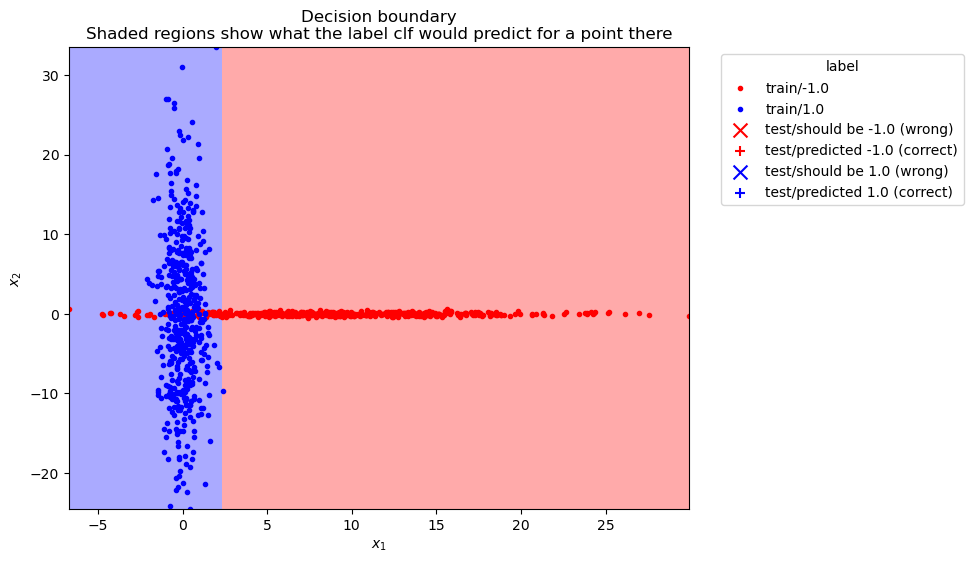

In [33]:
x, y = source_3(1000)
for name,method in methods.items():
    method.fit(x,y)
    print(f'Source 3 Method {name}')
    plot_decision_boundary(method,x,y)
    plt.show()

Source 2 Method Unispherical
Source 2 Method Diag


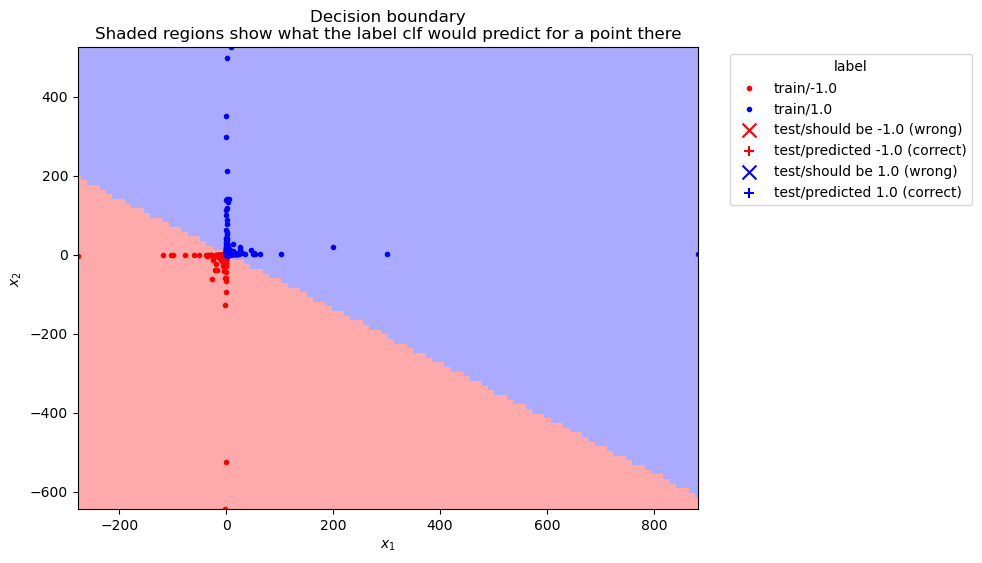

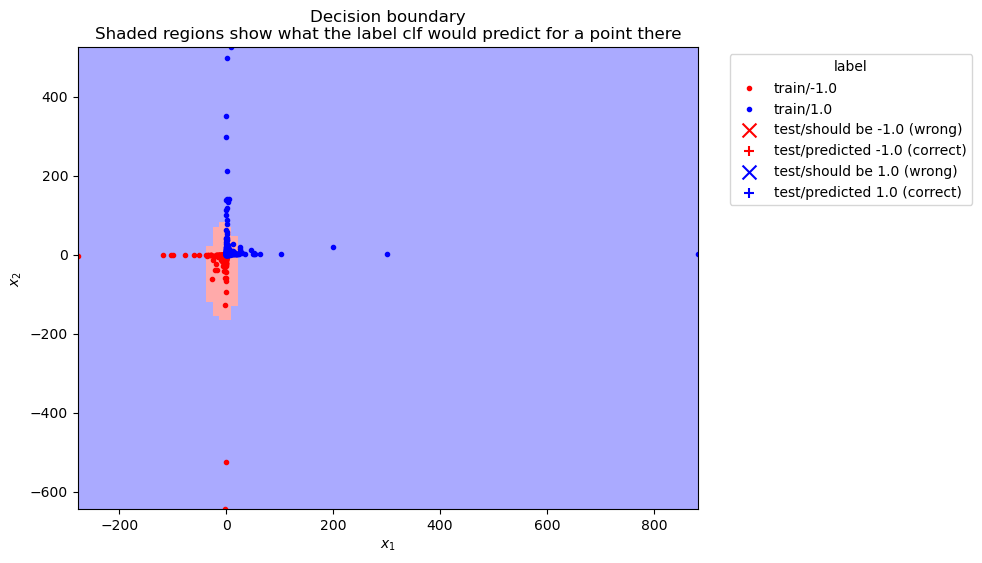

In [ ]:
x,y = source_4_2d(1000)
clf = methods['unispherical']
clf.fit(x,y)
print(f'Source 4 Method Unispherical')
plot_decision_boundary(clf,x,y)
clf = methods['diag']
clf.fit(x,y)
print(f'Source 4 Method Diag')
plot_decision_boundary(clf,x,y)

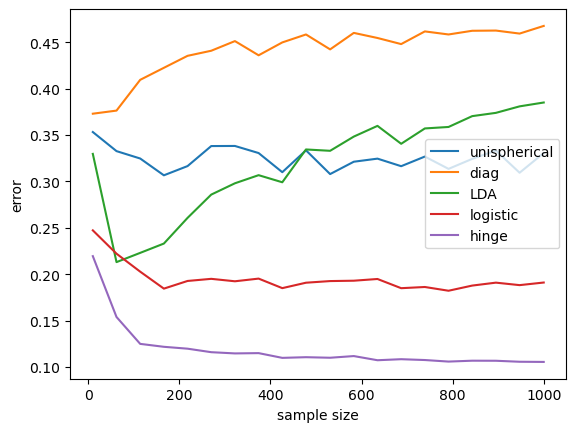

{'unispherical': array([0.353173, 0.332618, 0.324657, 0.306559, 0.316497, 0.338064,
        0.338177, 0.330539, 0.309923, 0.333488, 0.30788 , 0.321195,
        0.32452 , 0.316379, 0.326761, 0.313492, 0.32425 , 0.333239,
        0.309329, 0.33057 ]),
 'diag': array([0.37292 , 0.376268, 0.409404, 0.422351, 0.435263, 0.440742,
        0.451129, 0.435844, 0.449703, 0.458268, 0.442201, 0.459966,
        0.45448 , 0.447904, 0.461563, 0.45827 , 0.462252, 0.462476,
        0.459225, 0.467474]),
 'LDA': array([0.329643, 0.213057, 0.223015, 0.233046, 0.260714, 0.285789,
        0.297971, 0.306713, 0.299062, 0.334407, 0.332957, 0.348272,
        0.359812, 0.340516, 0.35705 , 0.358635, 0.370305, 0.373833,
        0.380827, 0.384982]),
 'logistic': array([0.247271, 0.222127, 0.202783, 0.184499, 0.192759, 0.19504 ,
        0.192413, 0.195295, 0.185026, 0.190872, 0.192639, 0.193029,
        0.19488 , 0.184971, 0.18626 , 0.182224, 0.187786, 0.190943,
        0.188263, 0.19107 ]),
 'hinge': array([0.21

In [35]:
try_methods_on_data(source_5, methods=methods, max_train=1000, test_size=10000, min_train=10, num_sizes=20,num_rep=100)

Source 5 Method unispherical


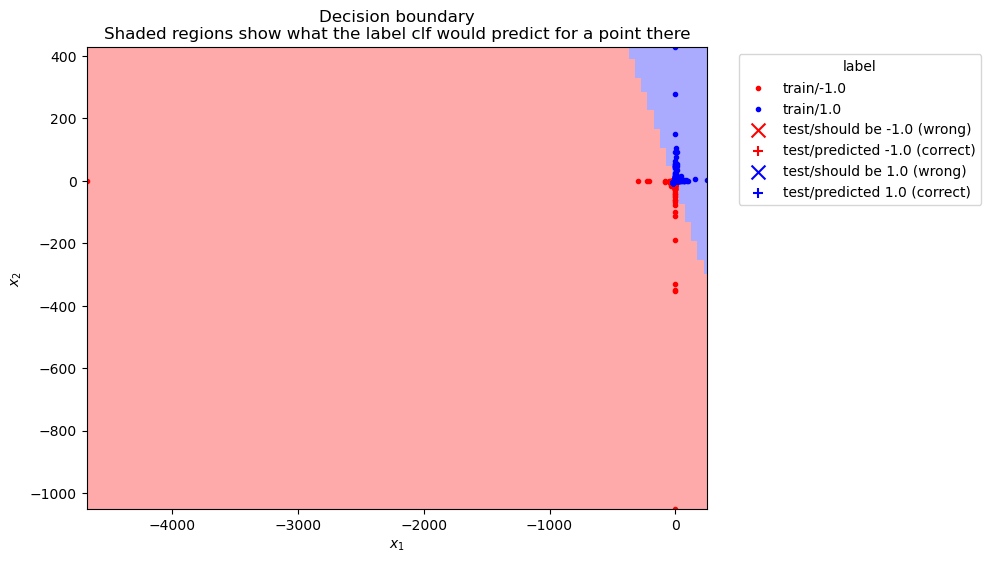

Source 5 Method diag


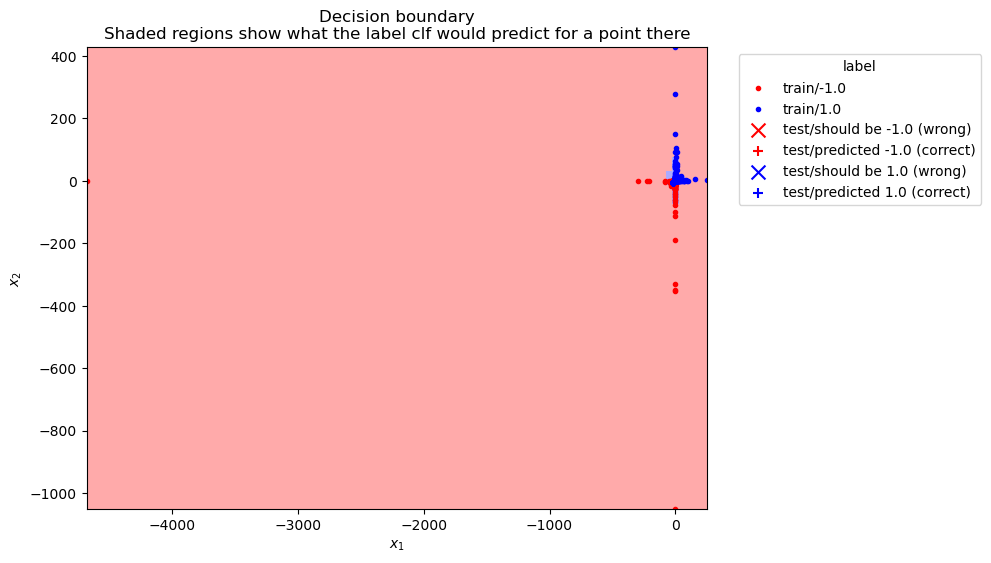

Source 5 Method LDA


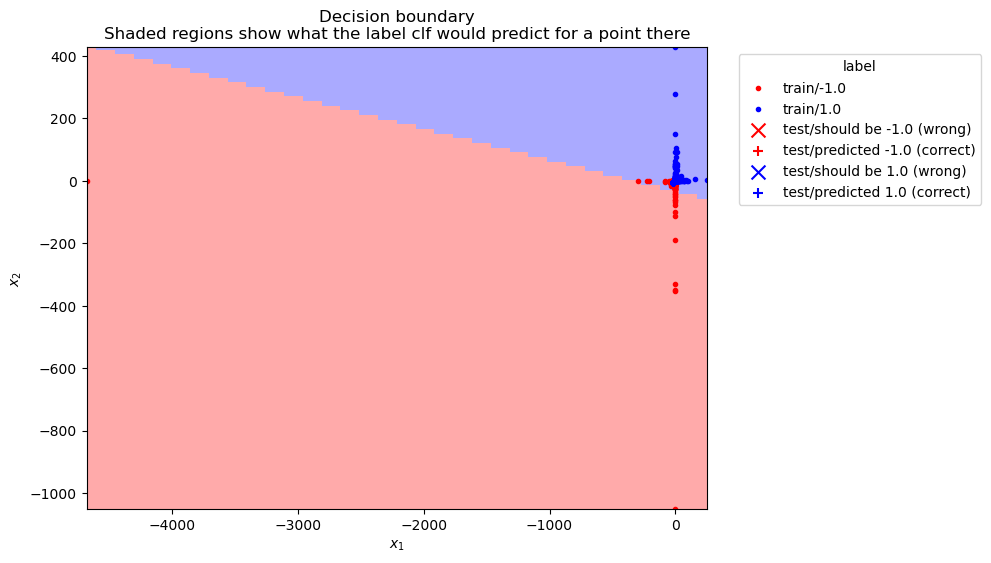

Source 5 Method logistic


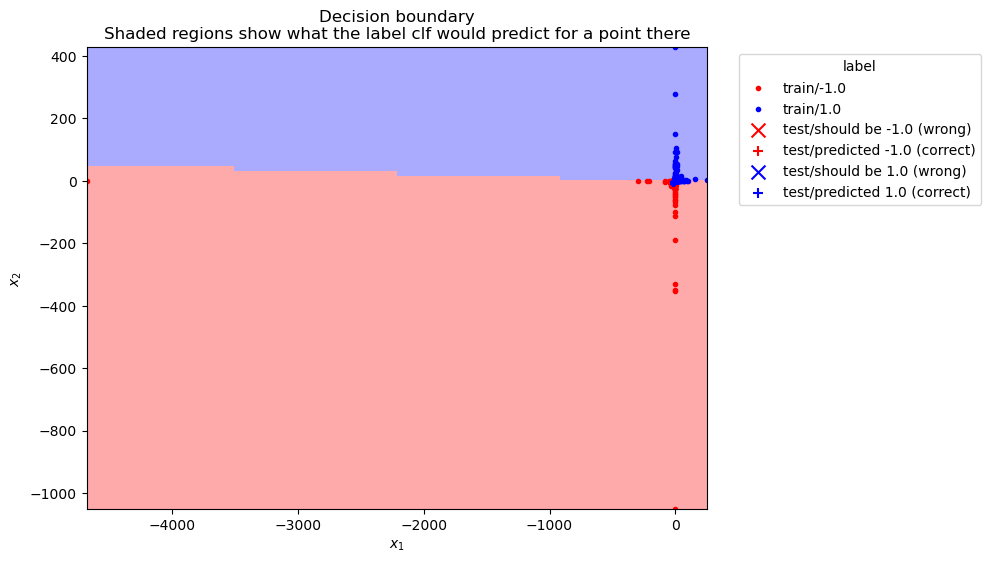

Source 5 Method hinge


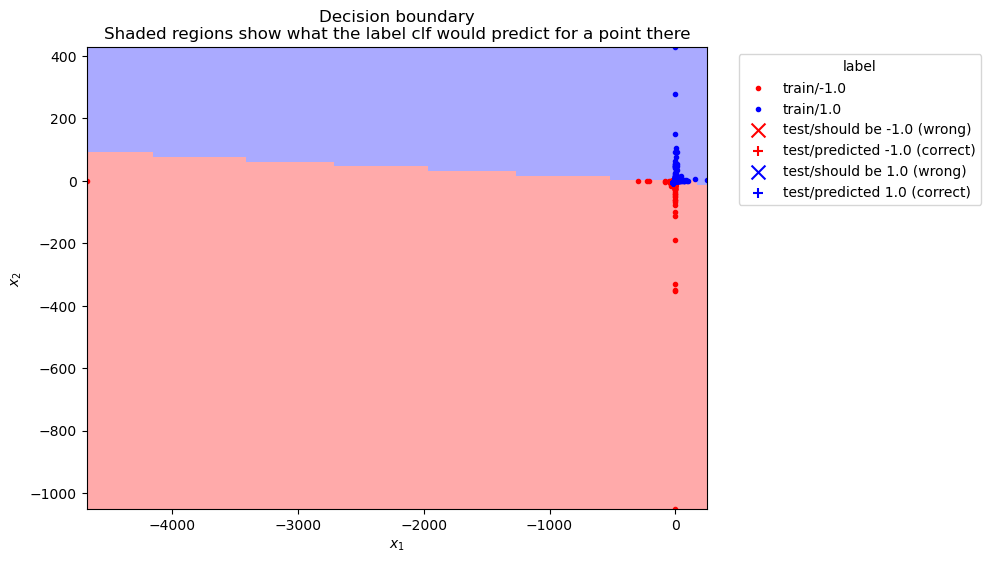

In [36]:
x, y = source_5_2d(1000)
for name,method in methods.items():
    method.fit(x,y)
    print(f'Source 5 Method {name}')
    plot_decision_boundary(method,x,y)
    plt.show()

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 1]</h4>

For each of `source_1`, `source_2`, `source_3`, `source_4`, `source_5`:
* Run `try_methods_on_data` to investigate how the different methods perform on them. By default, it investigates training sets of sizes 10 to 300. However, you should make sure to adjust this range for each source distribution to understand what is happening. You may also need to adjust num_rep.
* In a couple sentences, explain why you get the behavior that you get. Discuss the behavior of the method with small $m$, large $m$, and when $m\rightarrow\infty$. Compare to the Bayes Error. It might be useful and insightful to `plot_decision_boundary` on some specific training set sizes and methods. You can include some of these plots in your explanation. <br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer: 

For source 1, all of the methods performed very similarly. This is because this dgp can be correctly specified by all of the methods. 

For source 2, there were two methods that performed poorly. The unit spherical and the diagonal gaussian mixture methods didn't perform well because they weren't able to take into account the skewness of the data. 

For source 3, the diagonal gaussian mixture model was flexible enough to be able to have a conic section decision boundary. The hinge and logistic loss did better than the unit spherical and the LDA methods because they were able to minimize over their linear predictor instead of trying to minimize over the constraint that the gaussian mixtures must have the same covariance, which in this case is very misspecified.

For source 4, all the models performed relatively well except for the diagonal gaussian mixture, which as a result of its feature map tried to find a conic section, which didn't really work for this problem.

For source 5, the gaussian mixture models all performed poorly because outliers really biased their decision boundaries. However, since the data was relatively separable, the hinge and logistic loss estimators were able to get margins that were fairly robust to outliers. The support vector machinery helped these models out a lot. When $m$ was small, all of the models performed similarly, however, as $m$ increases, the gaussian mixture models, sensitive to the fat tails of the distribution were really thrown off by the large number of outliers, while the soft margin predictors were quite robust. 
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

### [Optional Task 3] $k$-th Order Markov Model

In the written homework, you have seen how to use a Markov model as a generative classifier on text documents. We will generalize it into a $k$-th order Markov Model and restate the definition below.


### Generative Model Description

We assume a uniform distribution over labels, meaning each document topic is chosen with equal probability. The generative process for a document follows a **topic-dependent stationary Markov chain** of order $k$, defined as follows:

1. **Topic Selection:**  
   - A topic $y$ is drawn from a uniform distribution:  

     $$ y \sim \text{Unif}(\{1, -1\}) $$

2. **Generating the First $k$ Words:**  
   - The first word $w_1$ is sampled from a topic-specific initial distribution:  

     $$ w_1 \sim p_{y, \text{init}}(w_1) $$

   - For $i = 2, \dots, k$, each word is sampled **conditionally on the topic $y$ and all preceding words**:  

     $$ w_i \sim p_{y, \text{init}}(w_i | w_1, \dots, w_{i-1}) $$

   - These **partial initial distributions** ensure that early words (before a full $k$-gram context exists) are generated correctly.
   - Here, $p_{y, \text{init}}$ represents **topic-specific probability distributions** over the vocabulary.

3. **Generating Subsequent Words (Markov Assumption):**  
   - Each subsequent word $w_i$ for $i > k$ is sampled **conditionally on the topic $y$ and the preceding $k$ words**:

     $$ w_i \sim p_{y, \text{tran}}(w_i | w_{i-k}, \dots, w_{i-1}) $$

   - The transition probability $p_{y, \text{tran}}$ captures the dependence of $w_i$ on the previous $k$ words in the sequence.
   - Given $y$ and the preceding $k$ words, the choice of $w_i$ is **independent** of all earlier words $w_1, \dots, w_{i-k-1}$. In other words, **the sequence follows a stationary $k$-th order Markov chain conditioned on $y$**.

4. **Parameterization:**  
   - The model is fully specified by the parameters:

     $$ \{ p_{y, \text{init}}(\cdot), p_{y, \text{init}}(\cdot | \cdot), p_{y, \text{tran}}(\cdot | \cdot) \}_{y \in \{1, -1\}} $$
     
   - The **initial distribution** $p_{y, \text{init}}$ is a probability vector over the vocabulary:

     $$ \sum_{w} p_{y, \text{init}}(w) = 1, \quad \forall y $$

   - The **partial initial distributions** for the first $k$ words satisfy:

     $$ \sum_{w_i} p_{y, \text{init}}(w_i | w_1, \dots, w_{i-1}) = 1, \quad \forall y, \forall i \in \{2, \dots, k\} $$

   - The **transition distribution** $p_{y, \text{tran}}(w_i | w_{i-k}, \dots, w_{i-1})$ forms a **stochastic transition matrix**, where each conditional probability distribution over $w_i$ sums to 1:

     $$ \sum_{w_i} p_{y, \text{tran}}(w_i | w_{i-k}, \dots, w_{i-1}) = 1, \quad \forall y, \forall (w_{i-k}, \dots, w_{i-1}) $$


<!-- ## Implementation Tricks Not Covered in the General Description -->

In the implementation of the Markov model below, we applied several practical techniques to ensure robustness, numerical stability, and efficiency. These techniques were not explicitly mentioned in the theoretical description but are crucial for real-world application.

<!-- --- -->

 **1. Handling Unseen Words with `<UNK>` Token**

**Why?**  
- Words that appear in test data but were never seen in training must be handled gracefully to prevent errors and unrealistic zero probabilities.

**Implementation Trick:**  
- When building vocabulary from training set, we filter out rare words (appearing less than `min_freq` times).
- Words not in the training vocabulary (including those filtered out at first step) are mapped to `<UNK>`, ensuring smooth probability calculations.
- `<UNK>` is explicitly included in:
  - The **initial word distribution** $p_{y,\text{init}}$.
  - The **transition distribution** $p_{y,\text{tran}}$.


 **2. Smoothing with Pseudo-Counts (Laplace Smoothing)**

**Why?**  
- To avoid zero probabilities for unseen transitions or first words.

**Implementation Trick:**  
- We add a **small pseudo-count ($\alpha$)** to all probability calculations. This is equivalent to using $\text{Dirichlet}(\alpha)$ as a prior distribution for $p_{y,\text{init}}$ and $p_{y,\text{tran}}$.
  - **Initial word probabilities**:  

    $$ p_{y,\text{init}}(w) = \frac{\text{count}(w) + \alpha}{\sum \text{count}(w) + \alpha N} $$

  - **Transition probabilities**:

    $$ p_{y,\text{tran}}(w_i | w_{i-k}, \dots, w_{i-1}) = \frac{\text{count}(\cdot) + \alpha}{\sum \text{count}(\cdot) + \alpha N} $$
    
  - Prevents probabilities from ever being exactly zero.


In [ ]:
from collections import defaultdict, Counter

class MarkovModel:
    def __init__(self, k, alpha=1.0):
        """
        k: Order of the Markov model
        alpha: Smoothing parameter (pseudo-count)
        """
        self.k = k
        self.alpha = alpha
        self.transition_probs = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
        self.partial_initial_probs = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
        self.initial_probs = defaultdict(lambda: defaultdict(float))
        self.vocab = None

    def fit(self, sentences, labels, min_freq=2):
        """
        Trains a k-th order Markov model using Maximum Likelihood Estimation (MLE).
        Adds initial probabilities for the first k words.
        """
        class_ngrams = {c: defaultdict(int) for c in set(labels)}
        class_transitions = {c: defaultdict(lambda: defaultdict(int)) for c in set(labels)}
        initial_counts = {c: defaultdict(int) for c in set(labels)}
        partial_initial_counts = {c: defaultdict(lambda: defaultdict(int)) for c in set(labels)}
        word_counts = Counter()

        # Count word frequencies first
        for sentence, label in zip(sentences, labels):
            tokens = sentence.lower().split()
            word_counts.update(tokens)

        # Filter vocabulary
        vocab = {word for word, count in word_counts.items() if count >= min_freq}
        vocab.add("<UNK>")
        self.vocab = vocab

        # Count n-gram occurrences and transitions per class
        for sentence, label in zip(sentences, labels):
            tokens = [word if word in self.vocab else "<UNK>" for word in sentence.lower().split()]

            # Count first word probability
            if tokens:
                initial_counts[label][tokens[0]] += 1

            # Count partial initial probabilities for w_2 to w_k
            for i in range(1, min(self.k, len(tokens))):
                history = tuple(tokens[:i])  # Get prefix context
                partial_initial_counts[label][history][tokens[i]] += 1

            # Count full k-th order transitions
            for i in range(len(tokens) - self.k):
                ngram = tuple(tokens[i:i+self.k])
                next_word = tokens[i+self.k]
                class_ngrams[label][ngram] += 1
                class_transitions[label][ngram][next_word] += 1

        # Compute initial probabilities
        for c in initial_counts:
            total_initial_count = sum(initial_counts[c].values()) + self.alpha * len(vocab)
            for word in vocab:
                self.initial_probs[c][word] = (initial_counts[c].get(word, 0) + self.alpha) / total_initial_count

        # Compute partial initial probabilities
        for c in partial_initial_counts:
            for history in partial_initial_counts[c]:
                total_count = sum(partial_initial_counts[c][history].values()) + self.alpha * len(vocab)
                for word in vocab:
                    self.partial_initial_probs[c][history][word] = (
                        partial_initial_counts[c][history].get(word, 0) + self.alpha
                    ) / total_count

        # Compute transition probabilities
        for c in class_transitions:
            for ngram in class_transitions[c]:
                total_count = class_ngrams[c][ngram] + self.alpha * len(vocab)
                for word in vocab:
                    self.transition_probs[c][ngram][word] = (
                        class_transitions[c][ngram].get(word, 0) + self.alpha
                    ) / total_count

    def predict(self, sentences):
        """
        Predicts the most likely class using a Naive Bayes-style decision rule.
        """
        preds = []
        for sentence in sentences:
            tokens = [word if word in self.vocab else "<UNK>" for word in sentence.lower().split()]
            class_scores = {c: 0 for c in self.transition_probs}

            # Compute probability of first word
            if tokens:
                first_word = tokens[0]
                for c in class_scores:
                    class_scores[c] += np.log(self.initial_probs[c].get(first_word, self.alpha / len(self.vocab)))

            # Compute probability of words 2 to k
            for i in range(1, min(self.k, len(tokens))):
                history = tuple(tokens[:i])
                next_word = tokens[i]
                for c in class_scores:
                    prob = self.partial_initial_probs[c].get(history, {}).get(next_word, self.alpha / len(self.vocab))
                    class_scores[c] += np.log(prob)

            # Compute transition probabilities for words k+1 onwards
            for i in range(len(tokens) - self.k):
                ngram = tuple(tokens[i:i+self.k])
                next_word = tokens[i+self.k]
                for c in class_scores:
                    prob = self.transition_probs[c].get(ngram, {}).get(next_word, self.alpha / len(self.vocab))
                    class_scores[c] += np.log(prob)

            preds.append(max(class_scores, key=class_scores.get))
        return np.array(preds)


We will compare the Markov model with logistic regression. In order to get a fair comparison, we will use a new `kGramVectorizer`. Each document is represented as a sequence of words. To reduce noise, rare words appearing fewer than `min_freq` times are filtered out, and they plus unseen words are replaced with a special `<UNK>` token. The vectorizer then constructs a feature vector where each dimension corresponds to a specific $k$-gram, encoding its frequency within the document.

In [ ]:
class kGramVectorizer:
    def __init__(self, sentences, k, min_freq=2):
        """
        Extracts k-th order tuple features from sentences.
        Filters out words that appear less than `min_freq` times.
        """
        self.k = k
        self.min_freq = min_freq
        self.ngram_counts = defaultdict(int)

        # Step 1: Count word frequencies
        word_counts = Counter()
        for sentence in sentences:
            tokens = sentence.lower().split()
            word_counts.update(tokens)

        # Step 2: Filter vocabulary (keep words appearing at least `min_freq` times)
        self.vocab = {word for word, count in word_counts.items() if count >= min_freq}
        self.vocab.add("<UNK>")  # Add unknown token

        # Step 3: Collect k-grams and transitions using filtered vocabulary
        for sentence in sentences:
            tokens = [word if word in self.vocab else "<UNK>" for word in sentence.lower().split()]
            for i in range(len(tokens) - k):
                ngram = tuple(tokens[i:i+k])
                next_word = tokens[i+k]
                self.ngram_counts[ngram] += 1

    def vectorize(self, sentences):
        """
        Convert sentences into n-gram feature vectors.
        """
        vectors = np.zeros((len(sentences), len(self.ngram_counts)))
        ngram_list = list(self.ngram_counts.keys())
        ngram_dict = {ngram: i for i, ngram in enumerate(ngram_list)}

        for i, sentence in enumerate(sentences):
            tokens = [word if word in self.vocab else "<UNK>" for word in sentence.lower().split()]
            for j in range(len(tokens) - self.k + 1):
                ngram = tuple(tokens[j:j+self.k])
                if ngram in ngram_dict:
                    vectors[i][ngram_dict[ngram]] += 1
        return vectors

Now we will compare the generative approach and the discriminative method on the Spam dataset that we are very familiar with. We will just use $k=2$ and `min_freq` as $2$, i.e., exclude the words that only appear once in the training set. You need to report the error on the test set and answer the question.

In [ ]:
!mkdir $PWD/data
!wget  -O $PWD/data/SMSSpamCollection https://www.dropbox.com/scl/fi/mdobhv2gwvvswe9ujtn7v/SMSSpamCollection?rlkey=80xp0dzb70tthuvuv9fuda0fk&dl=1

In [ ]:
import os

k=2
min_freq=2
Xr, yr = read_sms_spam_data(os.path.join(os.getcwd(), 'data/SMSSpamCollection'))

spamdata = TrainAndTestData(*create_split(Xr, yr, 0.9))

In [ ]:
## Markov Model

markov_model = MarkovModel(k, alpha=1.0)
markov_model.fit(spamdata.X_train, spamdata.y_train, min_freq=min_freq)
spamdata.print_errors(markov_model)

In [ ]:
## discriminative model

from sklearn.linear_model import LogisticRegression
Vectorizer = kGramVectorizer(spamdata.X_train, k=k, min_freq=min_freq)
vectorized_data = TrainAndTestData(Vectorizer.vectorize(spamdata.X_train), spamdata.y_train, Vectorizer.vectorize(spamdata.X_test), spamdata.y_test)
logistic_model_sklearn=LogisticRegression()
logistic_model_sklearn.fit(vectorized_data.X_train, vectorized_data.y_train)
vectorized_data.print_errors(logistic_model_sklearn)

<span style="color: red">
<h4 style="font-weight: bold">[Optional Question 2]</h4>

What method have better performance on the Spam dataset? In general, do generative methods or discriminative methods have better performance? What's the potential reason of the disadvantage of generative model here?<br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer:

</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

You are encouraged to try different $k$ to see how the performance of the Markov model changes. Can you further improve the performance of a Markov Model? Here are some example directions you can explore.

1. Using Marginal Word Probabilities When $w_{t-k}, \dots, w_{t-1}$ is Unknown
- If a past sequence $(w_{t-k}, \dots, w_{t-1})$ is unseen in training, the implementation above just use a uniform distribution.
- Instead of using a uniform probability ($1/N$), we fall back to the **marginal probability** of the next word:
  $$ p(w) = \frac{\text{count}(w) + \alpha}{\sum \text{count}(w) + \alpha N} $$
- This ensures that the model still generates reasonable predictions for unseen contexts.

2. Backoff Smoothing (Using Lower-Order Models)

- If a k-th order n-gram is missing, fall back to a lower-order (e.g., unigram or bigram).
- More flexible than relying only on `<UNK>`.

3. Prior Distribution on $y$.

- We fixed the marginal distribution of $y$ as uniform distribution. Instead, you can use a Dirichlet distribution as the prior distribution of $y$ as learned in the written homework.
- This will work better on an imbalanced dataset.


# Summary

Statistician George Box famously said that, "All models are wrong, but some are useful." You've seen some of that for yourself here -- there are certain settings in which specifying the model a certain way allows us to learn with higher accuracy / better generalization, and other settings in which a different specification of the model is better. Even within the landscape of modern machine learning, we've moved away from generative models for certain kinds of tasks (image classification, image segmentation, etc). However, for other problems, we have well-understood and well-specified models that do help us better make sense of what is going on when we receive new data. The field of inverse problems seeks to identify appropriate values for parameters based on a known generative model. While we will not discuss this further in our class, there are classes available at UChicago to study this topic further. Here are some papers that consider generative approaches:

* [Can one hear the shape of a drum?](https://eclass.uoa.gr/modules/document/file.php/MATH379/2.%20%CE%86%CF%81%CE%B8%CF%81%CE%B1%3A%20American%20Mathematical%20Monthly/Can%20one%20hear%20the%20shape%20of%20a%20drum.pdf)

* [Model-Based Estimation of Respiratory Parameters from Capnography, with Application to Diagnosing Obstructive Lung Disease](https://dspace.mit.edu/bitstream/handle/1721.1/134854/07915749.pdf?sequence=2&isAllowed=y)